In [1]:
import getopt
import sys
import gc
import os
sys.path.append('/home/atac2rna/program/atac2rna/Model/butterfly/Butterfly/')
from data_processing import RNA_data_preprocessing, ATAC_data_preprocessing
import scanpy as sc
import anndata as ad
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from model_component import *
from model_utlis import *
from calculate_cluster import *
from draw_cluster import *
from data_processing import *
from logger import *

In [2]:
import getopt
import sys
import gc
import os
sys.path.append('/home/atac2rna/program/atac2rna/Model/butterfly/Butterfly/')
from data_processing import RNA_data_preprocessing, ATAC_data_preprocessing
import scanpy as sc
import anndata as ad

data = 'MK'
ATAC_data = sc.read_h5ad('/home/atac2rna/data/atac2rna/data/scCAS_220601/sciCAR_mm10_kdiney/sciCAR_mm10_kdiney_ATAC_unknown.h5ad')
RNA_data = sc.read_h5ad('/home/atac2rna/data/atac2rna/data/scCAS_220601/sciCAR_mm10_kdiney/sciCAR_mm10_kdiney_RNA_unknown.h5ad')

# basic multiVI

In [3]:
from scvi_colab import install
import pandas as pd
install()
import scvi
import sys
from calculate_cluster import *
import scipy.sparse as sp
from split_datasets import *

                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
Global seed set to 0


In [4]:
adata = ad.AnnData(sp.hstack((RNA_data.X, ATAC_data.X)))
adata.X = adata.X.tocsr()
adata.obs = RNA_data.obs

m = len(RNA_data.var.index)
n = len(ATAC_data.var.index)
adata.var.index = pd.Series([RNA_data.var.index[i] if i<m else ATAC_data.var.index[i-m] for i in range(m+n)], dtype='object')
adata.var['modality'] = pd.Series(['Gene Expression' if i<m else 'Peaks' for i in range(m+n)], dtype='object').values

adata.var_names_make_unique()

adata_mvi = scvi.data.organize_multiome_anndatas(adata)

adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()

sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='modality')

mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
)

In [5]:
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 11296 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 15633 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

In [6]:
mvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 251/500:  50%|███████████████████████████████████████████████████▋                                                   | 251/500 [14:41<14:34,  3.51s/it, loss=1.28e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 2568.618. Signaling Trainer to stop.


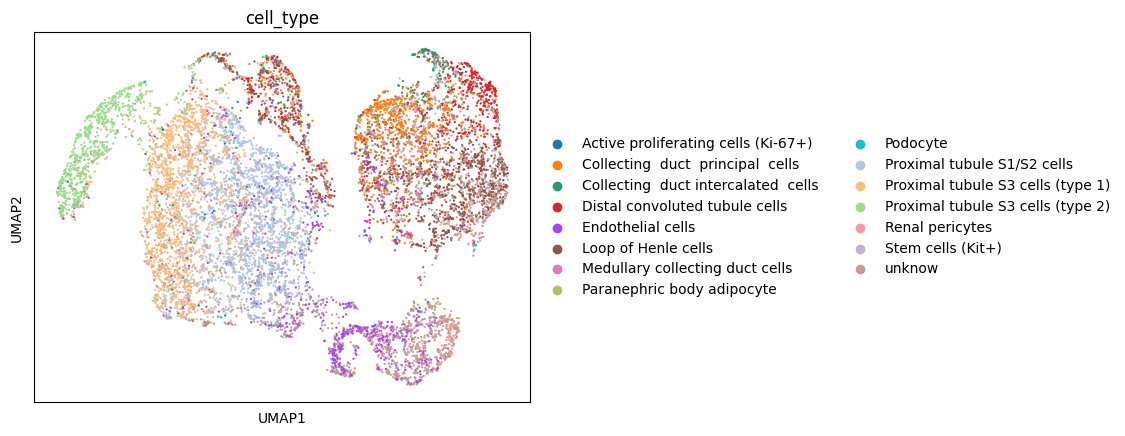

In [7]:
adata_mvi.obsm["MultiVI_latent"] = mvi.get_latent_representation()
sc.pp.neighbors(adata_mvi, use_rep="MultiVI_latent")
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color='cell_type', title='cell_type')

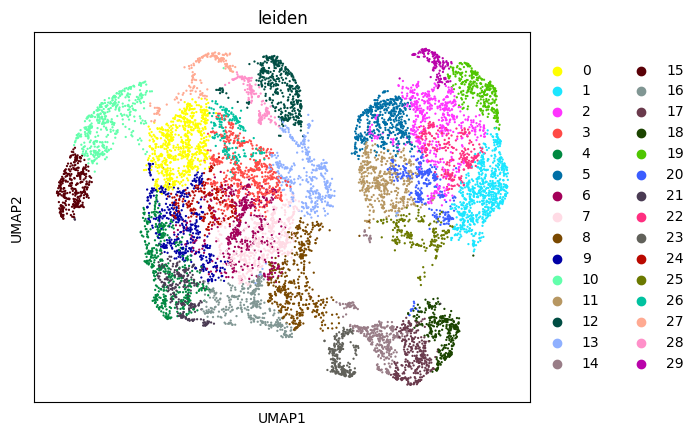

In [8]:
sc.tl.leiden(adata_mvi)
sc.pl.umap(adata_mvi, color='leiden', title='leiden')

In [4]:
import scanpy as sc
import anndata as ad
import episcanpy as epi
import sklearn
from sklearn import metrics


def calculate_cluster_index(adata):
    """
    Evaluation of cluster index of prediction. 
    Cluster method have two types:  Leiden
                         Louvain. 
    Index have eight types:   Adjusted Rand Index
                      Rand Index
                      Normalized Mutual Information
                      Adjusted Mutual Information
                      Homogeneity
                      Completeness
                      V-measure
                      Fowlkes-Mallows Scores
    
    Parameters
    ----------
    adata
        Anndata need to calculate, it's worth noting that there should be 'cell_type' in adata.obs.
        
    """  
    sc.tl.leiden(adata)
    sc.tl.louvain(adata)

    ARI_leiden = metrics.adjusted_rand_score(adata.obs['cell_type'], adata.obs['leiden'])
    AMI_leiden = metrics.adjusted_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden'])
    NMI_leiden = metrics.normalized_mutual_info_score(adata.obs['cell_type'], adata.obs['leiden'])
    HOM_leiden = metrics.homogeneity_score(adata.obs['cell_type'], adata.obs['leiden'])
    COM_leiden = metrics.completeness_score(adata.obs['cell_type'], adata.obs['leiden'])
    V_measure_leiden = metrics.v_measure_score(adata.obs['cell_type'], adata.obs['leiden'])
    
    return ARI_leiden, AMI_leiden, NMI_leiden, HOM_leiden, COM_leiden, V_measure_leiden

In [10]:
calculate_cluster_index(adata_mvi)

(0.1370745082843637,
 0.3365211192986217,
 0.3409789715081891,
 0.42250771088906075,
 0.2858250522081841,
 0.340978971508189)

# butterfly predict

In [5]:
file_path = '/home/atac2rna/data/atac2rna/model_output/22_10_12/multiVI_use_prediction/temp'

In [6]:
RNA_data = RNA_data_preprocessing(
    RNA_data,
    normalize_total=True,
    log1p=True,
    use_hvg=True,
    n_top_genes=3000,
    save_data=False,
    file_path=file_path,
    logging_path=file_path
    )
ATAC_data, divide_title, multiply_title, max_temp = ATAC_data_preprocessing(
    ATAC_data,
    binary_data=True,
    filter_features=True,
    fpeaks=0.005,
    tfidf=True,
    normalize=True,
    save_data=False,
    file_path=file_path,
    logging_path=file_path
)
R2A_predict = []
A2R_predict = []
test_id_a = [i for i in range(RNA_data.X.shape[0])]
test_id_r = [i for i in range(RNA_data.X.shape[0])]

# Part 3 calculate chrom list
chrom_list = []
last_one = ''
for i in range(len(ATAC_data.var.peak)):
    temp = ATAC_data.var.peak[i].split('_')[0]
    if temp[0 : 3] == 'chr':
        if not temp == last_one:
            chrom_list.append(1)
            last_one = temp
        else:
            chrom_list[-1] += 1
    else:
        chrom_list[-1] += 1

from train_model import Model
import torch
import torch.nn as nn

RNA_input_dim = len([i for i in RNA_data.var['highly_variable'] if i])
ATAC_input_dim = ATAC_data.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = 1 / ATAC_input_dim * 20
kl_div = R_kl_div + A_kl_div

############################################################
# Part 4 construct model
model = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ATAC_input_dim, 32 * len(chrom_list), 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 32 * len(chrom_list), ATAC_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.Sigmoid()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0.3,
    chrom_list = chrom_list,
    logging_path = file_path,
    RNA_data = RNA_data,
    ATAC_data = ATAC_data
)

model_path = "/home/atac2rna/data/atac2rna/model_output/22_10_12/multiVI_use_prediction/"+str(data)+"/1"
load_model = True
output_path = file_path
test_evaluate = False
test_cluster = True
test_umap = True
output_data = False

if load_model:
    model.RNA_encoder.load_state_dict(torch.load(model_path + '/model/RNA_encoder.pt'))
    model.ATAC_encoder.load_state_dict(torch.load(model_path + '/model/ATAC_encoder.pt'))
    model.RNA_decoder.load_state_dict(torch.load(model_path + '/model/RNA_decoder.pt'))
    model.ATAC_decoder.load_state_dict(torch.load(model_path + '/model/ATAC_decoder.pt'))
    model.translator.load_state_dict(torch.load(model_path + '/model/translator.pt'))

""" load data """
RNA_input_dim = model.RNA_data.shape[1]
ATAC_input_dim = model.ATAC_data.shape[1]

model.R_test_dataset = Single_omics_dataset(model.RNA_data, test_id_r)
model.A_test_dataset = Single_omics_dataset(model.ATAC_data, test_id_a)
model.R_test_dataloader = DataLoader(model.R_test_dataset, batch_size=100, shuffle=False, num_workers=4)
model.A_test_dataloader = DataLoader(model.A_test_dataset, batch_size=100, shuffle=False, num_workers=4)

model.set_eval()

""" record the predicted data """
with torch.no_grad():
    with tqdm(total = len(model.A_test_dataloader), ncols=150, colour='blue') as pbar:
        pbar.set_description('ATAC to RNA predicting...')
        for idx, batch_samples in enumerate(model.A_test_dataloader):
            if torch.cuda.is_available():
                batch_samples = batch_samples.cuda().to(torch.float32)

            A2 = model.ATAC_encoder(batch_samples)
            A2R, A2A, mu_a, sigma_a = model.translator.test_model(A2, 'ATAC')
            A2R = model.RNA_decoder(A2R)

            A2R_predict.append(A2R.cpu())                       

            time.sleep(0.01)
            pbar.update(1)

with torch.no_grad():
    with tqdm(total = len(model.R_test_dataloader), ncols=150, colour='blue') as pbar:
        pbar.set_description('RNA to ATAC predicting...')
        for idx, batch_samples in enumerate(model.R_test_dataloader):
            if torch.cuda.is_available():
                batch_samples = batch_samples.cuda().to(torch.float32)

            R2 = model.RNA_encoder(batch_samples)
            R2R, R2A, mu_r, sigma_r = model.translator.test_model(R2, 'RNA')
            R2A = model.ATAC_decoder(R2A)

            R2A_predict.append(R2A.cpu())                       

            time.sleep(0.01)
            pbar.update(1)


1
2
3


RNA to ATAC predicting...: 100%|████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:02<00:00, 42.89it/s]


In [7]:
A2R_predict = tensor2adata(A2R_predict)
A2R_predict.obs = RNA_data.obs.iloc[test_id_r, :]
A2R_predict.var = RNA_data.var

R2A_predict = tensor2adata(R2A_predict)
R2A_predict.obs = ATAC_data.obs.iloc[test_id_r, :]
R2A_predict.var = ATAC_data.var

In [8]:
R2A_predict.X = inverse_TFIDF(R2A_predict.X, divide_title[:, test_id_a], multiply_title[:, test_id_a], max_temp)
R2A_predict.X[R2A_predict.X > np.mean(R2A_predict.X, axis=1)] = 1
R2A_predict.X[R2A_predict.X < np.mean(R2A_predict.X, axis=1)] = 0

In [9]:
del divide_title, multiply_title
import gc
gc.collect()

32

In [10]:
adata = ad.AnnData(sp.hstack((A2R_predict.X, R2A_predict.X)))
adata.X = adata.X.tocsr()
adata.obs = A2R_predict.obs

m = len(A2R_predict.var.index)
n = len(R2A_predict.var.index)
adata.var.index = pd.Series([A2R_predict.var.index[i] if i<m else R2A_predict.var.index[i-m] for i in range(m+n)], dtype='object')
adata.var['modality'] = pd.Series(['Gene Expression' if i<m else 'Peaks' for i in range(m+n)], dtype='object').values

adata.var_names_make_unique()

adata = scvi.data.organize_multiome_anndatas(adata)

adata = adata[:, adata.var["modality"].argsort()].copy()

scvi.model.MULTIVI.setup_anndata(adata, batch_key='modality')

mvi = scvi.model.MULTIVI(
    adata,
    n_genes=(adata.var['modality']=='Gene Expression').sum(),
    n_regions=(adata.var['modality']=='Peaks').sum(),
)

In [11]:
mvi.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 11296 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 32382 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

In [12]:
mvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Epoch 1/500:   0%|                                                                                                                                                                          | 0/500 [00:00<?, ?it/s]

Epoch 2/500:   0%|▎                                                                                                                                         | 1/500 [00:03<29:16,  3.52s/it, loss=7.69e+03, v_num=1]

Epoch 3/500:   0%|▌                                                                                                                                         | 2/500 [00:07<29:11,  3.52s/it, loss=6.73e+03, v_num=1]

Epoch 4/500:   1%|▊                                                                                                                                         | 3/500 [00:10<29:15,  3.53s/it, loss=6.45e+03, v_num=1]

Epoch 5/500:   1%|█                                                                                                                                         | 4/500 [00:14<29:04,  3.52s/it, loss=6.07e+03, v_num=1]

Epoch 6/500:   1%|█▍                                                                                                                                        | 5/500 [00:17<29:00,  3.52s/it, loss=5.66e+03, v_num=1]

Epoch 7/500:   1%|█▋                                                                                                                                        | 6/500 [00:21<29:03,  3.53s/it, loss=5.48e+03, v_num=1]

Epoch 8/500:   1%|█▉                                                                                                                                         | 7/500 [00:24<29:02,  3.53s/it, loss=5.1e+03, v_num=1]

Epoch 9/500:   2%|██▏                                                                                                                                       | 8/500 [00:28<29:05,  3.55s/it, loss=5.04e+03, v_num=1]

Epoch 10/500:   2%|██▍                                                                                                                                      | 9/500 [00:31<29:05,  3.56s/it, loss=4.95e+03, v_num=1]

Epoch 11/500:   2%|██▋                                                                                                                                     | 10/500 [00:35<29:00,  3.55s/it, loss=4.87e+03, v_num=1]

Epoch 12/500:   2%|██▉                                                                                                                                     | 11/500 [00:39<29:28,  3.62s/it, loss=4.76e+03, v_num=1]

Epoch 13/500:   2%|███▎                                                                                                                                    | 12/500 [00:42<29:17,  3.60s/it, loss=4.59e+03, v_num=1]

Epoch 14/500:   3%|███▌                                                                                                                                     | 13/500 [00:46<29:16,  3.61s/it, loss=4.5e+03, v_num=1]

Epoch 15/500:   3%|███▊                                                                                                                                    | 14/500 [00:49<29:07,  3.60s/it, loss=4.37e+03, v_num=1]

Epoch 16/500:   3%|████                                                                                                                                    | 15/500 [00:53<29:02,  3.59s/it, loss=4.38e+03, v_num=1]

Epoch 17/500:   3%|████▍                                                                                                                                    | 16/500 [00:57<29:07,  3.61s/it, loss=4.3e+03, v_num=1]

Epoch 18/500:   3%|████▌                                                                                                                                   | 17/500 [01:00<28:59,  3.60s/it, loss=4.23e+03, v_num=1]

Epoch 19/500:   4%|████▉                                                                                                                                    | 18/500 [01:04<28:46,  3.58s/it, loss=4.2e+03, v_num=1]

Epoch 20/500:   4%|█████▏                                                                                                                                  | 19/500 [01:07<28:43,  3.58s/it, loss=4.09e+03, v_num=1]

Epoch 21/500:   4%|█████▍                                                                                                                                  | 20/500 [01:11<28:43,  3.59s/it, loss=4.04e+03, v_num=1]

Epoch 22/500:   4%|█████▋                                                                                                                                  | 21/500 [01:15<28:51,  3.62s/it, loss=3.97e+03, v_num=1]

Epoch 23/500:   4%|█████▉                                                                                                                                  | 22/500 [01:18<28:55,  3.63s/it, loss=3.88e+03, v_num=1]

Epoch 24/500:   5%|██████▎                                                                                                                                 | 23/500 [01:22<28:57,  3.64s/it, loss=3.78e+03, v_num=1]

Epoch 25/500:   5%|██████▌                                                                                                                                 | 24/500 [01:26<28:50,  3.64s/it, loss=3.75e+03, v_num=1]

Epoch 26/500:   5%|██████▊                                                                                                                                 | 25/500 [01:29<28:58,  3.66s/it, loss=3.65e+03, v_num=1]

Epoch 27/500:   5%|███████                                                                                                                                 | 26/500 [01:33<28:57,  3.67s/it, loss=3.57e+03, v_num=1]

Epoch 28/500:   5%|███████▎                                                                                                                                | 27/500 [01:37<29:00,  3.68s/it, loss=3.58e+03, v_num=1]

Epoch 29/500:   6%|███████▌                                                                                                                                | 28/500 [01:40<28:51,  3.67s/it, loss=3.49e+03, v_num=1]

Epoch 30/500:   6%|███████▉                                                                                                                                | 29/500 [01:44<28:40,  3.65s/it, loss=3.46e+03, v_num=1]

Epoch 31/500:   6%|████████▏                                                                                                                               | 30/500 [01:48<28:22,  3.62s/it, loss=3.41e+03, v_num=1]

Epoch 32/500:   6%|████████▍                                                                                                                               | 31/500 [01:51<28:10,  3.60s/it, loss=3.35e+03, v_num=1]

Epoch 33/500:   6%|████████▋                                                                                                                               | 32/500 [01:55<27:57,  3.58s/it, loss=3.37e+03, v_num=1]

Epoch 34/500:   7%|█████████                                                                                                                                | 33/500 [01:58<28:00,  3.60s/it, loss=3.3e+03, v_num=1]

Epoch 35/500:   7%|█████████▏                                                                                                                              | 34/500 [02:02<28:03,  3.61s/it, loss=3.27e+03, v_num=1]

Epoch 36/500:   7%|█████████▌                                                                                                                              | 35/500 [02:06<28:05,  3.63s/it, loss=3.25e+03, v_num=1]

Epoch 37/500:   7%|█████████▊                                                                                                                              | 36/500 [02:09<27:38,  3.57s/it, loss=3.17e+03, v_num=1]

Epoch 38/500:   7%|██████████                                                                                                                              | 37/500 [02:13<27:39,  3.58s/it, loss=3.14e+03, v_num=1]

Epoch 39/500:   8%|██████████▎                                                                                                                             | 38/500 [02:16<28:02,  3.64s/it, loss=3.12e+03, v_num=1]

Epoch 40/500:   8%|██████████▌                                                                                                                             | 39/500 [02:20<28:00,  3.64s/it, loss=3.08e+03, v_num=1]

Epoch 41/500:   8%|██████████▉                                                                                                                             | 40/500 [02:24<28:02,  3.66s/it, loss=3.03e+03, v_num=1]

Epoch 42/500:   8%|███████████▏                                                                                                                            | 41/500 [02:27<28:07,  3.68s/it, loss=3.03e+03, v_num=1]

Epoch 43/500:   8%|███████████▋                                                                                                                               | 42/500 [02:31<28:06,  3.68s/it, loss=3e+03, v_num=1]

Epoch 44/500:   9%|███████████▋                                                                                                                            | 43/500 [02:35<27:51,  3.66s/it, loss=2.94e+03, v_num=1]

Epoch 45/500:   9%|███████████▉                                                                                                                            | 44/500 [02:38<27:49,  3.66s/it, loss=2.94e+03, v_num=1]

Epoch 46/500:   9%|████████████▏                                                                                                                           | 45/500 [02:42<27:00,  3.56s/it, loss=2.92e+03, v_num=1]

Epoch 47/500:   9%|████████████▌                                                                                                                           | 46/500 [02:45<27:08,  3.59s/it, loss=2.89e+03, v_num=1]

Epoch 48/500:   9%|████████████▊                                                                                                                           | 47/500 [02:49<27:24,  3.63s/it, loss=2.87e+03, v_num=1]

Epoch 49/500:  10%|█████████████                                                                                                                           | 48/500 [02:53<27:36,  3.67s/it, loss=2.85e+03, v_num=1]

Epoch 50/500:  10%|█████████████▎                                                                                                                          | 49/500 [02:57<28:01,  3.73s/it, loss=2.82e+03, v_num=1]

Epoch 51/500:  10%|█████████████▋                                                                                                                           | 50/500 [03:00<27:34,  3.68s/it, loss=2.8e+03, v_num=1]

Epoch 52/500:  10%|█████████████▊                                                                                                                          | 51/500 [03:04<27:17,  3.65s/it, loss=2.78e+03, v_num=1]

Epoch 53/500:  10%|██████████████▏                                                                                                                         | 52/500 [03:07<27:10,  3.64s/it, loss=2.77e+03, v_num=1]

Epoch 54/500:  11%|██████████████▍                                                                                                                         | 53/500 [03:11<27:03,  3.63s/it, loss=2.72e+03, v_num=1]

Epoch 55/500:  11%|██████████████▋                                                                                                                         | 54/500 [03:15<26:55,  3.62s/it, loss=2.67e+03, v_num=1]

Epoch 56/500:  11%|██████████████▉                                                                                                                         | 55/500 [03:18<26:43,  3.60s/it, loss=2.69e+03, v_num=1]

Epoch 57/500:  11%|███████████████▏                                                                                                                        | 56/500 [03:22<26:51,  3.63s/it, loss=2.64e+03, v_num=1]

Epoch 58/500:  11%|███████████████▌                                                                                                                        | 57/500 [03:26<26:54,  3.65s/it, loss=2.66e+03, v_num=1]

Epoch 59/500:  12%|███████████████▊                                                                                                                        | 58/500 [03:29<26:51,  3.65s/it, loss=2.64e+03, v_num=1]

Epoch 60/500:  12%|████████████████▏                                                                                                                        | 59/500 [03:33<26:49,  3.65s/it, loss=2.6e+03, v_num=1]

Epoch 61/500:  12%|████████████████▎                                                                                                                       | 60/500 [03:37<27:01,  3.68s/it, loss=2.59e+03, v_num=1]

Epoch 62/500:  12%|████████████████▌                                                                                                                       | 61/500 [03:40<26:48,  3.66s/it, loss=2.53e+03, v_num=1]

Epoch 63/500:  12%|████████████████▊                                                                                                                       | 62/500 [03:44<26:40,  3.65s/it, loss=2.55e+03, v_num=1]

Epoch 64/500:  13%|█████████████████▏                                                                                                                      | 63/500 [03:47<26:14,  3.60s/it, loss=2.54e+03, v_num=1]

Epoch 65/500:  13%|█████████████████▍                                                                                                                      | 64/500 [03:51<26:18,  3.62s/it, loss=2.54e+03, v_num=1]

Epoch 66/500:  13%|█████████████████▋                                                                                                                      | 65/500 [03:55<26:03,  3.60s/it, loss=2.53e+03, v_num=1]

Epoch 67/500:  13%|█████████████████▉                                                                                                                      | 66/500 [03:58<26:13,  3.63s/it, loss=2.48e+03, v_num=1]

Epoch 68/500:  13%|██████████████████▏                                                                                                                     | 67/500 [04:02<26:23,  3.66s/it, loss=2.46e+03, v_num=1]

Epoch 69/500:  14%|██████████████████▍                                                                                                                     | 68/500 [04:06<26:30,  3.68s/it, loss=2.42e+03, v_num=1]

Epoch 70/500:  14%|██████████████████▊                                                                                                                     | 69/500 [04:10<26:29,  3.69s/it, loss=2.44e+03, v_num=1]

Epoch 71/500:  14%|███████████████████                                                                                                                     | 70/500 [04:13<26:27,  3.69s/it, loss=2.44e+03, v_num=1]

Epoch 72/500:  14%|███████████████████▎                                                                                                                    | 71/500 [04:17<26:21,  3.69s/it, loss=2.41e+03, v_num=1]

Epoch 73/500:  14%|███████████████████▌                                                                                                                    | 72/500 [04:21<26:21,  3.69s/it, loss=2.39e+03, v_num=1]

Epoch 74/500:  15%|███████████████████▊                                                                                                                    | 73/500 [04:24<26:17,  3.69s/it, loss=2.39e+03, v_num=1]

Epoch 75/500:  15%|████████████████████▏                                                                                                                   | 74/500 [04:28<26:47,  3.77s/it, loss=2.34e+03, v_num=1]

Epoch 76/500:  15%|████████████████████▍                                                                                                                   | 75/500 [04:32<26:32,  3.75s/it, loss=2.34e+03, v_num=1]

Epoch 77/500:  15%|████████████████████▋                                                                                                                   | 76/500 [04:36<26:29,  3.75s/it, loss=2.33e+03, v_num=1]

Epoch 78/500:  15%|████████████████████▉                                                                                                                   | 77/500 [04:39<26:02,  3.69s/it, loss=2.29e+03, v_num=1]

Epoch 79/500:  16%|█████████████████████▏                                                                                                                  | 78/500 [04:43<25:52,  3.68s/it, loss=2.29e+03, v_num=1]

Epoch 80/500:  16%|█████████████████████▍                                                                                                                  | 79/500 [04:47<25:55,  3.69s/it, loss=2.29e+03, v_num=1]

Epoch 81/500:  16%|█████████████████████▊                                                                                                                  | 80/500 [04:50<25:58,  3.71s/it, loss=2.27e+03, v_num=1]

Epoch 82/500:  16%|██████████████████████                                                                                                                  | 81/500 [04:54<26:13,  3.76s/it, loss=2.26e+03, v_num=1]

Epoch 83/500:  16%|██████████████████████▎                                                                                                                 | 82/500 [04:58<26:19,  3.78s/it, loss=2.24e+03, v_num=1]

Epoch 84/500:  17%|██████████████████████▋                                                                                                                  | 83/500 [05:02<26:25,  3.80s/it, loss=2.2e+03, v_num=1]

Epoch 85/500:  17%|██████████████████████▊                                                                                                                 | 84/500 [05:06<26:16,  3.79s/it, loss=2.22e+03, v_num=1]

Epoch 86/500:  17%|███████████████████████                                                                                                                 | 85/500 [05:10<26:23,  3.82s/it, loss=2.19e+03, v_num=1]

Epoch 87/500:  17%|███████████████████████▌                                                                                                                 | 86/500 [05:13<25:57,  3.76s/it, loss=2.2e+03, v_num=1]

Epoch 88/500:  17%|███████████████████████▋                                                                                                                | 87/500 [05:17<25:39,  3.73s/it, loss=2.17e+03, v_num=1]

Epoch 89/500:  18%|███████████████████████▉                                                                                                                | 88/500 [05:21<25:26,  3.71s/it, loss=2.14e+03, v_num=1]

Epoch 90/500:  18%|████████████████████████▏                                                                                                               | 89/500 [05:24<25:17,  3.69s/it, loss=2.15e+03, v_num=1]

Epoch 91/500:  18%|████████████████████████▍                                                                                                               | 90/500 [05:28<25:06,  3.67s/it, loss=2.13e+03, v_num=1]

Epoch 92/500:  18%|████████████████████████▊                                                                                                               | 91/500 [05:31<24:39,  3.62s/it, loss=2.14e+03, v_num=1]

Epoch 93/500:  18%|█████████████████████████▏                                                                                                               | 92/500 [05:35<24:39,  3.63s/it, loss=2.1e+03, v_num=1]

Epoch 94/500:  19%|█████████████████████████▎                                                                                                              | 93/500 [05:39<24:43,  3.64s/it, loss=2.11e+03, v_num=1]

Epoch 95/500:  19%|█████████████████████████▌                                                                                                              | 94/500 [05:42<24:45,  3.66s/it, loss=2.13e+03, v_num=1]

Epoch 96/500:  19%|█████████████████████████▊                                                                                                              | 95/500 [05:46<24:40,  3.66s/it, loss=2.06e+03, v_num=1]

Epoch 97/500:  19%|██████████████████████████                                                                                                              | 96/500 [05:50<24:54,  3.70s/it, loss=2.06e+03, v_num=1]

Epoch 98/500:  19%|██████████████████████████▍                                                                                                             | 97/500 [05:53<24:51,  3.70s/it, loss=2.06e+03, v_num=1]

Epoch 99/500:  20%|██████████████████████████▋                                                                                                             | 98/500 [05:57<24:48,  3.70s/it, loss=2.02e+03, v_num=1]

Epoch 100/500:  20%|██████████████████████████▋                                                                                                            | 99/500 [06:01<24:46,  3.71s/it, loss=2.03e+03, v_num=1]

Epoch 101/500:  20%|██████████████████████████▊                                                                                                           | 100/500 [06:04<24:29,  3.67s/it, loss=2.04e+03, v_num=1]

Epoch 102/500:  20%|███████████████████████████▋                                                                                                             | 101/500 [06:08<24:17,  3.65s/it, loss=2e+03, v_num=1]

Epoch 103/500:  20%|███████████████████████████▉                                                                                                             | 102/500 [06:12<24:09,  3.64s/it, loss=2e+03, v_num=1]

Epoch 104/500:  21%|███████████████████████████▌                                                                                                          | 103/500 [06:15<24:16,  3.67s/it, loss=1.96e+03, v_num=1]

Epoch 105/500:  21%|███████████████████████████▊                                                                                                          | 104/500 [06:19<24:22,  3.69s/it, loss=1.95e+03, v_num=1]

Epoch 106/500:  21%|████████████████████████████▏                                                                                                         | 105/500 [06:23<24:20,  3.70s/it, loss=1.96e+03, v_num=1]

Epoch 107/500:  21%|████████████████████████████▍                                                                                                         | 106/500 [06:27<24:19,  3.70s/it, loss=1.95e+03, v_num=1]

Epoch 108/500:  21%|████████████████████████████▋                                                                                                         | 107/500 [06:30<24:19,  3.71s/it, loss=1.94e+03, v_num=1]

Epoch 109/500:  22%|████████████████████████████▉                                                                                                         | 108/500 [06:34<24:14,  3.71s/it, loss=1.92e+03, v_num=1]

Epoch 110/500:  22%|█████████████████████████████▍                                                                                                         | 109/500 [06:38<23:56,  3.67s/it, loss=1.9e+03, v_num=1]

Epoch 111/500:  22%|█████████████████████████████▍                                                                                                        | 110/500 [06:41<23:35,  3.63s/it, loss=1.89e+03, v_num=1]

Epoch 112/500:  22%|█████████████████████████████▋                                                                                                        | 111/500 [06:45<23:18,  3.59s/it, loss=1.89e+03, v_num=1]

Epoch 113/500:  22%|██████████████████████████████                                                                                                        | 112/500 [06:48<22:44,  3.52s/it, loss=1.89e+03, v_num=1]

Epoch 114/500:  23%|██████████████████████████████▌                                                                                                        | 113/500 [06:52<22:42,  3.52s/it, loss=1.9e+03, v_num=1]

Epoch 115/500:  23%|██████████████████████████████▌                                                                                                       | 114/500 [06:55<22:44,  3.54s/it, loss=1.87e+03, v_num=1]

Epoch 116/500:  23%|██████████████████████████████▊                                                                                                       | 115/500 [06:59<22:37,  3.53s/it, loss=1.85e+03, v_num=1]

Epoch 117/500:  23%|███████████████████████████████                                                                                                       | 116/500 [07:02<22:34,  3.53s/it, loss=1.85e+03, v_num=1]

Epoch 118/500:  23%|███████████████████████████████▎                                                                                                      | 117/500 [07:05<21:58,  3.44s/it, loss=1.83e+03, v_num=1]

Epoch 119/500:  24%|███████████████████████████████▌                                                                                                      | 118/500 [07:09<22:08,  3.48s/it, loss=1.82e+03, v_num=1]

Epoch 120/500:  24%|████████████████████████████████▏                                                                                                      | 119/500 [07:13<22:18,  3.51s/it, loss=1.8e+03, v_num=1]

Epoch 121/500:  24%|████████████████████████████████▏                                                                                                     | 120/500 [07:15<21:07,  3.33s/it, loss=1.81e+03, v_num=1]

Epoch 122/500:  24%|████████████████████████████████▋                                                                                                      | 121/500 [07:19<21:05,  3.34s/it, loss=1.8e+03, v_num=1]

Epoch 123/500:  24%|████████████████████████████████▋                                                                                                     | 122/500 [07:22<21:33,  3.42s/it, loss=1.78e+03, v_num=1]

Epoch 124/500:  25%|████████████████████████████████▉                                                                                                     | 123/500 [07:26<21:55,  3.49s/it, loss=1.77e+03, v_num=1]

Epoch 125/500:  25%|█████████████████████████████████▏                                                                                                    | 124/500 [07:30<22:05,  3.52s/it, loss=1.76e+03, v_num=1]

Epoch 126/500:  25%|█████████████████████████████████▌                                                                                                    | 125/500 [07:33<22:14,  3.56s/it, loss=1.76e+03, v_num=1]

Epoch 127/500:  25%|█████████████████████████████████▊                                                                                                    | 126/500 [07:37<22:10,  3.56s/it, loss=1.73e+03, v_num=1]

Epoch 128/500:  25%|██████████████████████████████████                                                                                                    | 127/500 [07:40<22:05,  3.55s/it, loss=1.77e+03, v_num=1]

Epoch 129/500:  26%|██████████████████████████████████▎                                                                                                   | 128/500 [07:44<22:04,  3.56s/it, loss=1.73e+03, v_num=1]

Epoch 130/500:  26%|██████████████████████████████████▌                                                                                                   | 129/500 [07:48<22:03,  3.57s/it, loss=1.72e+03, v_num=1]

Epoch 131/500:  26%|██████████████████████████████████▊                                                                                                   | 130/500 [07:51<22:07,  3.59s/it, loss=1.71e+03, v_num=1]

Epoch 132/500:  26%|███████████████████████████████████                                                                                                   | 131/500 [07:55<22:28,  3.65s/it, loss=1.69e+03, v_num=1]

Epoch 133/500:  26%|███████████████████████████████████▋                                                                                                   | 132/500 [07:59<22:25,  3.66s/it, loss=1.7e+03, v_num=1]

Epoch 134/500:  27%|███████████████████████████████████▋                                                                                                  | 133/500 [08:02<22:13,  3.63s/it, loss=1.69e+03, v_num=1]

Epoch 135/500:  27%|███████████████████████████████████▉                                                                                                  | 134/500 [08:06<21:56,  3.60s/it, loss=1.69e+03, v_num=1]

Epoch 136/500:  27%|████████████████████████████████████▏                                                                                                 | 135/500 [08:09<21:46,  3.58s/it, loss=1.67e+03, v_num=1]

Epoch 137/500:  27%|████████████████████████████████████▍                                                                                                 | 136/500 [08:13<21:46,  3.59s/it, loss=1.66e+03, v_num=1]

Epoch 138/500:  27%|████████████████████████████████████▋                                                                                                 | 137/500 [08:17<22:07,  3.66s/it, loss=1.67e+03, v_num=1]

Epoch 139/500:  28%|████████████████████████████████████▉                                                                                                 | 138/500 [08:21<22:32,  3.74s/it, loss=1.64e+03, v_num=1]

Epoch 140/500:  28%|█████████████████████████████████████▎                                                                                                | 139/500 [08:24<22:17,  3.71s/it, loss=1.62e+03, v_num=1]

Epoch 141/500:  28%|█████████████████████████████████████▌                                                                                                | 140/500 [08:28<23:04,  3.85s/it, loss=1.63e+03, v_num=1]

Epoch 142/500:  28%|█████████████████████████████████████▊                                                                                                | 141/500 [08:32<23:03,  3.85s/it, loss=1.61e+03, v_num=1]

Epoch 143/500:  28%|██████████████████████████████████████                                                                                                | 142/500 [08:36<23:07,  3.88s/it, loss=1.61e+03, v_num=1]

Epoch 144/500:  29%|██████████████████████████████████████▎                                                                                               | 143/500 [08:40<23:10,  3.89s/it, loss=1.61e+03, v_num=1]

Epoch 145/500:  29%|██████████████████████████████████████▌                                                                                               | 144/500 [08:44<22:54,  3.86s/it, loss=1.59e+03, v_num=1]

Epoch 146/500:  29%|██████████████████████████████████████▊                                                                                               | 145/500 [08:48<22:53,  3.87s/it, loss=1.59e+03, v_num=1]

Epoch 147/500:  29%|███████████████████████████████████████▏                                                                                              | 146/500 [08:52<23:09,  3.93s/it, loss=1.58e+03, v_num=1]

Epoch 148/500:  29%|███████████████████████████████████████▍                                                                                              | 147/500 [08:56<23:03,  3.92s/it, loss=1.58e+03, v_num=1]

Epoch 149/500:  30%|███████████████████████████████████████▋                                                                                              | 148/500 [09:00<23:41,  4.04s/it, loss=1.56e+03, v_num=1]

Epoch 150/500:  30%|███████████████████████████████████████▉                                                                                              | 149/500 [09:04<23:28,  4.01s/it, loss=1.57e+03, v_num=1]

Epoch 151/500:  30%|████████████████████████████████████████▏                                                                                             | 150/500 [09:08<22:49,  3.91s/it, loss=1.55e+03, v_num=1]

Epoch 152/500:  30%|████████████████████████████████████████▍                                                                                             | 151/500 [09:12<22:25,  3.86s/it, loss=1.54e+03, v_num=1]

Epoch 153/500:  30%|████████████████████████████████████████▋                                                                                             | 152/500 [09:15<22:03,  3.80s/it, loss=1.52e+03, v_num=1]

Epoch 154/500:  31%|█████████████████████████████████████████                                                                                             | 153/500 [09:19<21:36,  3.74s/it, loss=1.51e+03, v_num=1]

Epoch 155/500:  31%|█████████████████████████████████████████▎                                                                                            | 154/500 [09:23<22:18,  3.87s/it, loss=1.52e+03, v_num=1]

Epoch 156/500:  31%|█████████████████████████████████████████▊                                                                                             | 155/500 [09:27<22:06,  3.85s/it, loss=1.5e+03, v_num=1]

Epoch 157/500:  31%|█████████████████████████████████████████▊                                                                                            | 156/500 [09:31<22:29,  3.92s/it, loss=1.49e+03, v_num=1]

Epoch 158/500:  31%|██████████████████████████████████████████                                                                                            | 157/500 [09:35<22:44,  3.98s/it, loss=1.51e+03, v_num=1]

Epoch 159/500:  32%|██████████████████████████████████████████▎                                                                                           | 158/500 [09:39<22:12,  3.90s/it, loss=1.47e+03, v_num=1]

Epoch 160/500:  32%|██████████████████████████████████████████▌                                                                                           | 159/500 [09:43<23:02,  4.05s/it, loss=1.48e+03, v_num=1]

Epoch 161/500:  32%|██████████████████████████████████████████▉                                                                                           | 160/500 [09:47<23:34,  4.16s/it, loss=1.48e+03, v_num=1]

Epoch 162/500:  32%|███████████████████████████████████████████▏                                                                                          | 161/500 [09:53<24:57,  4.42s/it, loss=1.47e+03, v_num=1]

Epoch 163/500:  32%|███████████████████████████████████████████▍                                                                                          | 162/500 [09:57<25:31,  4.53s/it, loss=1.46e+03, v_num=1]

Epoch 164/500:  33%|███████████████████████████████████████████▋                                                                                          | 163/500 [10:01<24:20,  4.33s/it, loss=1.44e+03, v_num=1]

Epoch 165/500:  33%|███████████████████████████████████████████▉                                                                                          | 164/500 [10:05<23:32,  4.20s/it, loss=1.43e+03, v_num=1]

Epoch 166/500:  33%|████████████████████████████████████████████▏                                                                                         | 165/500 [10:09<22:11,  3.97s/it, loss=1.44e+03, v_num=1]

Epoch 167/500:  33%|████████████████████████████████████████████▍                                                                                         | 166/500 [10:12<21:25,  3.85s/it, loss=1.41e+03, v_num=1]

Epoch 168/500:  33%|████████████████████████████████████████████▊                                                                                         | 167/500 [10:16<20:44,  3.74s/it, loss=1.43e+03, v_num=1]

Epoch 169/500:  34%|█████████████████████████████████████████████                                                                                         | 168/500 [10:19<20:33,  3.72s/it, loss=1.43e+03, v_num=1]

Epoch 170/500:  34%|█████████████████████████████████████████████▎                                                                                        | 169/500 [10:23<20:15,  3.67s/it, loss=1.41e+03, v_num=1]

Epoch 171/500:  34%|█████████████████████████████████████████████▌                                                                                        | 170/500 [10:26<20:12,  3.67s/it, loss=1.38e+03, v_num=1]

Epoch 172/500:  34%|█████████████████████████████████████████████▊                                                                                        | 171/500 [10:30<20:02,  3.66s/it, loss=1.38e+03, v_num=1]

Epoch 173/500:  34%|██████████████████████████████████████████████                                                                                        | 172/500 [10:34<19:59,  3.66s/it, loss=1.39e+03, v_num=1]

Epoch 174/500:  35%|██████████████████████████████████████████████▎                                                                                       | 173/500 [10:37<19:55,  3.66s/it, loss=1.38e+03, v_num=1]

Epoch 175/500:  35%|██████████████████████████████████████████████▋                                                                                       | 174/500 [10:41<19:40,  3.62s/it, loss=1.38e+03, v_num=1]

Epoch 176/500:  35%|██████████████████████████████████████████████▉                                                                                       | 175/500 [10:45<19:36,  3.62s/it, loss=1.38e+03, v_num=1]

Epoch 177/500:  35%|███████████████████████████████████████████████▏                                                                                      | 176/500 [10:48<19:35,  3.63s/it, loss=1.35e+03, v_num=1]

Epoch 178/500:  35%|███████████████████████████████████████████████▍                                                                                      | 177/500 [10:52<19:25,  3.61s/it, loss=1.37e+03, v_num=1]

Epoch 179/500:  36%|███████████████████████████████████████████████▋                                                                                      | 178/500 [10:56<19:37,  3.66s/it, loss=1.32e+03, v_num=1]

Epoch 180/500:  36%|███████████████████████████████████████████████▉                                                                                      | 179/500 [10:59<19:31,  3.65s/it, loss=1.34e+03, v_num=1]

Epoch 181/500:  36%|████████████████████████████████████████████████▏                                                                                     | 180/500 [11:03<19:22,  3.63s/it, loss=1.33e+03, v_num=1]

Epoch 182/500:  36%|████████████████████████████████████████████████▌                                                                                     | 181/500 [11:06<19:14,  3.62s/it, loss=1.32e+03, v_num=1]

Epoch 183/500:  36%|████████████████████████████████████████████████▊                                                                                     | 182/500 [11:10<19:05,  3.60s/it, loss=1.32e+03, v_num=1]

Epoch 184/500:  37%|█████████████████████████████████████████████████                                                                                     | 183/500 [11:14<19:10,  3.63s/it, loss=1.32e+03, v_num=1]

Epoch 185/500:  37%|█████████████████████████████████████████████████▎                                                                                    | 184/500 [11:17<19:04,  3.62s/it, loss=1.31e+03, v_num=1]

Epoch 186/500:  37%|█████████████████████████████████████████████████▌                                                                                    | 185/500 [11:21<19:03,  3.63s/it, loss=1.29e+03, v_num=1]

Epoch 187/500:  37%|█████████████████████████████████████████████████▊                                                                                    | 186/500 [11:25<19:08,  3.66s/it, loss=1.29e+03, v_num=1]

Epoch 188/500:  37%|██████████████████████████████████████████████████▍                                                                                    | 187/500 [11:28<18:58,  3.64s/it, loss=1.3e+03, v_num=1]

Epoch 189/500:  38%|██████████████████████████████████████████████████▍                                                                                   | 188/500 [11:32<18:53,  3.63s/it, loss=1.27e+03, v_num=1]

Epoch 190/500:  38%|██████████████████████████████████████████████████▋                                                                                   | 189/500 [11:35<18:50,  3.64s/it, loss=1.27e+03, v_num=1]

Epoch 191/500:  38%|██████████████████████████████████████████████████▉                                                                                   | 190/500 [11:39<18:42,  3.62s/it, loss=1.25e+03, v_num=1]

Epoch 192/500:  38%|███████████████████████████████████████████████████▏                                                                                  | 191/500 [11:43<18:37,  3.62s/it, loss=1.25e+03, v_num=1]

Epoch 193/500:  38%|███████████████████████████████████████████████████▍                                                                                  | 192/500 [11:46<18:35,  3.62s/it, loss=1.25e+03, v_num=1]

Epoch 194/500:  39%|███████████████████████████████████████████████████▋                                                                                  | 193/500 [11:50<18:32,  3.62s/it, loss=1.25e+03, v_num=1]

Epoch 195/500:  39%|███████████████████████████████████████████████████▉                                                                                  | 194/500 [11:54<18:34,  3.64s/it, loss=1.23e+03, v_num=1]

Epoch 196/500:  39%|████████████████████████████████████████████████████▎                                                                                 | 195/500 [11:57<18:25,  3.63s/it, loss=1.24e+03, v_num=1]

Epoch 197/500:  39%|████████████████████████████████████████████████████▌                                                                                 | 196/500 [12:01<18:22,  3.63s/it, loss=1.21e+03, v_num=1]

Epoch 198/500:  39%|████████████████████████████████████████████████████▊                                                                                 | 197/500 [12:04<18:18,  3.62s/it, loss=1.23e+03, v_num=1]

Epoch 199/500:  40%|█████████████████████████████████████████████████████                                                                                 | 198/500 [12:08<18:12,  3.62s/it, loss=1.22e+03, v_num=1]

Epoch 200/500:  40%|█████████████████████████████████████████████████████▎                                                                                | 199/500 [12:12<18:12,  3.63s/it, loss=1.22e+03, v_num=1]

Epoch 201/500:  40%|█████████████████████████████████████████████████████▌                                                                                | 200/500 [12:15<18:10,  3.63s/it, loss=1.21e+03, v_num=1]

Epoch 202/500:  40%|█████████████████████████████████████████████████████▊                                                                                | 201/500 [12:19<18:06,  3.63s/it, loss=1.21e+03, v_num=1]

Epoch 203/500:  40%|██████████████████████████████████████████████████████▏                                                                               | 202/500 [12:22<17:55,  3.61s/it, loss=1.19e+03, v_num=1]

Epoch 204/500:  41%|██████████████████████████████████████████████████████▊                                                                                | 203/500 [12:26<17:51,  3.61s/it, loss=1.2e+03, v_num=1]

Epoch 205/500:  41%|██████████████████████████████████████████████████████▋                                                                               | 204/500 [12:30<17:44,  3.60s/it, loss=1.19e+03, v_num=1]

Epoch 206/500:  41%|██████████████████████████████████████████████████████▉                                                                               | 205/500 [12:33<17:37,  3.59s/it, loss=1.18e+03, v_num=1]

Epoch 207/500:  41%|███████████████████████████████████████████████████████▏                                                                              | 206/500 [12:37<17:51,  3.64s/it, loss=1.18e+03, v_num=1]

Epoch 208/500:  41%|███████████████████████████████████████████████████████▍                                                                              | 207/500 [12:41<18:05,  3.70s/it, loss=1.15e+03, v_num=1]

Epoch 209/500:  42%|███████████████████████████████████████████████████████▋                                                                              | 208/500 [12:44<17:54,  3.68s/it, loss=1.17e+03, v_num=1]

Epoch 210/500:  42%|████████████████████████████████████████████████████████                                                                              | 209/500 [12:48<17:45,  3.66s/it, loss=1.15e+03, v_num=1]

Epoch 211/500:  42%|████████████████████████████████████████████████████████▎                                                                             | 210/500 [12:52<17:40,  3.66s/it, loss=1.15e+03, v_num=1]

Epoch 212/500:  42%|████████████████████████████████████████████████████████▌                                                                             | 211/500 [12:55<17:28,  3.63s/it, loss=1.14e+03, v_num=1]

Epoch 213/500:  42%|████████████████████████████████████████████████████████▊                                                                             | 212/500 [12:59<17:21,  3.62s/it, loss=1.12e+03, v_num=1]

Epoch 214/500:  43%|█████████████████████████████████████████████████████████                                                                             | 213/500 [13:02<17:15,  3.61s/it, loss=1.12e+03, v_num=1]

Epoch 215/500:  43%|█████████████████████████████████████████████████████████▎                                                                            | 214/500 [13:06<17:13,  3.61s/it, loss=1.13e+03, v_num=1]

Epoch 216/500:  43%|█████████████████████████████████████████████████████████▌                                                                            | 215/500 [13:10<17:07,  3.61s/it, loss=1.13e+03, v_num=1]

Epoch 217/500:  43%|█████████████████████████████████████████████████████████▉                                                                            | 216/500 [13:13<16:58,  3.59s/it, loss=1.12e+03, v_num=1]

Epoch 218/500:  43%|██████████████████████████████████████████████████████████▏                                                                           | 217/500 [13:17<16:52,  3.58s/it, loss=1.13e+03, v_num=1]

Epoch 219/500:  44%|██████████████████████████████████████████████████████████▊                                                                            | 218/500 [13:21<17:24,  3.70s/it, loss=1.1e+03, v_num=1]

Epoch 220/500:  44%|███████████████████████████████████████████████████████████▏                                                                           | 219/500 [13:24<17:13,  3.68s/it, loss=1.1e+03, v_num=1]

Epoch 221/500:  44%|███████████████████████████████████████████████████████████▍                                                                           | 220/500 [13:28<16:51,  3.61s/it, loss=1.1e+03, v_num=1]

Epoch 222/500:  44%|███████████████████████████████████████████████████████████▋                                                                           | 221/500 [13:31<16:48,  3.61s/it, loss=1.1e+03, v_num=1]

Epoch 223/500:  44%|███████████████████████████████████████████████████████████▉                                                                           | 222/500 [13:35<16:32,  3.57s/it, loss=1.1e+03, v_num=1]

Epoch 224/500:  45%|███████████████████████████████████████████████████████████▊                                                                          | 223/500 [13:39<16:28,  3.57s/it, loss=1.08e+03, v_num=1]

Epoch 225/500:  45%|████████████████████████████████████████████████████████████                                                                          | 224/500 [13:42<16:33,  3.60s/it, loss=1.09e+03, v_num=1]

Epoch 226/500:  45%|████████████████████████████████████████████████████████████▎                                                                         | 225/500 [13:46<16:51,  3.68s/it, loss=1.07e+03, v_num=1]

Epoch 227/500:  45%|████████████████████████████████████████████████████████████▌                                                                         | 226/500 [13:50<17:05,  3.74s/it, loss=1.06e+03, v_num=1]

Epoch 228/500:  45%|████████████████████████████████████████████████████████████▊                                                                         | 227/500 [13:54<16:49,  3.70s/it, loss=1.08e+03, v_num=1]

Epoch 229/500:  46%|█████████████████████████████████████████████████████████████                                                                         | 228/500 [13:57<16:34,  3.66s/it, loss=1.05e+03, v_num=1]

Epoch 230/500:  46%|█████████████████████████████████████████████████████████████▎                                                                        | 229/500 [14:01<16:26,  3.64s/it, loss=1.06e+03, v_num=1]

Epoch 231/500:  46%|█████████████████████████████████████████████████████████████▋                                                                        | 230/500 [14:04<16:24,  3.65s/it, loss=1.06e+03, v_num=1]

Epoch 232/500:  46%|█████████████████████████████████████████████████████████████▉                                                                        | 231/500 [14:08<16:17,  3.63s/it, loss=1.04e+03, v_num=1]

Epoch 233/500:  46%|██████████████████████████████████████████████████████████████▏                                                                       | 232/500 [14:12<16:10,  3.62s/it, loss=1.05e+03, v_num=1]

Epoch 234/500:  47%|██████████████████████████████████████████████████████████████▍                                                                       | 233/500 [14:15<16:06,  3.62s/it, loss=1.03e+03, v_num=1]

Epoch 235/500:  47%|██████████████████████████████████████████████████████████████▋                                                                       | 234/500 [14:19<16:06,  3.63s/it, loss=1.04e+03, v_num=1]

Epoch 236/500:  47%|██████████████████████████████████████████████████████████████▉                                                                       | 235/500 [14:22<16:01,  3.63s/it, loss=1.02e+03, v_num=1]

Epoch 237/500:  47%|███████████████████████████████████████████████████████████████▏                                                                      | 236/500 [14:26<15:51,  3.60s/it, loss=1.01e+03, v_num=1]

Epoch 238/500:  47%|███████████████████████████████████████████████████████████████▌                                                                      | 237/500 [14:30<15:49,  3.61s/it, loss=1.01e+03, v_num=1]

Epoch 239/500:  48%|██████████████████████████████████████████████████████████████████▏                                                                        | 238/500 [14:33<15:42,  3.60s/it, loss=999, v_num=1]

Epoch 240/500:  48%|██████████████████████████████████████████████████████████████████▍                                                                        | 239/500 [14:37<15:32,  3.57s/it, loss=998, v_num=1]

Epoch 241/500:  48%|████████████████████████████████████████████████████████████████▎                                                                     | 240/500 [14:40<15:26,  3.56s/it, loss=1.01e+03, v_num=1]

Epoch 242/500:  48%|████████████████████████████████████████████████████████████████▌                                                                     | 241/500 [14:44<15:15,  3.53s/it, loss=1.01e+03, v_num=1]

Epoch 243/500:  48%|███████████████████████████████████████████████████████████████████▎                                                                       | 242/500 [14:47<15:13,  3.54s/it, loss=992, v_num=1]

Epoch 244/500:  49%|███████████████████████████████████████████████████████████████████▌                                                                       | 243/500 [14:51<15:10,  3.54s/it, loss=985, v_num=1]

Epoch 245/500:  49%|███████████████████████████████████████████████████████████████████▊                                                                       | 244/500 [14:54<15:10,  3.56s/it, loss=985, v_num=1]

Epoch 246/500:  49%|████████████████████████████████████████████████████████████████████                                                                       | 245/500 [14:58<15:06,  3.55s/it, loss=989, v_num=1]

Epoch 247/500:  49%|████████████████████████████████████████████████████████████████████▍                                                                      | 246/500 [15:02<15:07,  3.57s/it, loss=981, v_num=1]

Epoch 248/500:  49%|████████████████████████████████████████████████████████████████████▋                                                                      | 247/500 [15:05<15:11,  3.60s/it, loss=960, v_num=1]

Epoch 249/500:  50%|████████████████████████████████████████████████████████████████████▉                                                                      | 248/500 [15:09<15:06,  3.60s/it, loss=951, v_num=1]

Epoch 250/500:  50%|█████████████████████████████████████████████████████████████████████▏                                                                     | 249/500 [15:12<15:01,  3.59s/it, loss=971, v_num=1]

Epoch 251/500:  50%|█████████████████████████████████████████████████████████████████████▌                                                                     | 250/500 [15:16<14:55,  3.58s/it, loss=962, v_num=1]

Epoch 252/500:  50%|█████████████████████████████████████████████████████████████████████▊                                                                     | 251/500 [15:20<14:55,  3.60s/it, loss=960, v_num=1]

Epoch 253/500:  50%|██████████████████████████████████████████████████████████████████████                                                                     | 252/500 [15:23<14:46,  3.57s/it, loss=967, v_num=1]

Epoch 254/500:  51%|██████████████████████████████████████████████████████████████████████▎                                                                    | 253/500 [15:27<14:37,  3.55s/it, loss=939, v_num=1]

Epoch 255/500:  51%|██████████████████████████████████████████████████████████████████████▌                                                                    | 254/500 [15:30<14:32,  3.55s/it, loss=955, v_num=1]

Epoch 256/500:  51%|██████████████████████████████████████████████████████████████████████▉                                                                    | 255/500 [15:34<14:29,  3.55s/it, loss=937, v_num=1]

Epoch 257/500:  51%|███████████████████████████████████████████████████████████████████████▏                                                                   | 256/500 [15:37<14:28,  3.56s/it, loss=944, v_num=1]

Epoch 258/500:  51%|███████████████████████████████████████████████████████████████████████▍                                                                   | 257/500 [15:41<14:29,  3.58s/it, loss=939, v_num=1]

Epoch 259/500:  52%|███████████████████████████████████████████████████████████████████████▋                                                                   | 258/500 [15:45<14:27,  3.58s/it, loss=944, v_num=1]

Epoch 260/500:  52%|████████████████████████████████████████████████████████████████████████                                                                   | 259/500 [15:48<14:22,  3.58s/it, loss=922, v_num=1]

Epoch 261/500:  52%|████████████████████████████████████████████████████████████████████████▎                                                                  | 260/500 [15:52<14:17,  3.57s/it, loss=915, v_num=1]

Epoch 262/500:  52%|████████████████████████████████████████████████████████████████████████▌                                                                  | 261/500 [15:55<14:10,  3.56s/it, loss=909, v_num=1]

Epoch 263/500:  52%|████████████████████████████████████████████████████████████████████████▊                                                                  | 262/500 [15:59<14:09,  3.57s/it, loss=925, v_num=1]

Epoch 264/500:  53%|█████████████████████████████████████████████████████████████████████████                                                                  | 263/500 [16:02<14:12,  3.60s/it, loss=911, v_num=1]

Epoch 265/500:  53%|█████████████████████████████████████████████████████████████████████████▍                                                                 | 264/500 [16:06<14:13,  3.61s/it, loss=913, v_num=1]

Epoch 266/500:  53%|█████████████████████████████████████████████████████████████████████████▋                                                                 | 265/500 [16:10<14:13,  3.63s/it, loss=879, v_num=1]

Epoch 267/500:  53%|█████████████████████████████████████████████████████████████████████████▉                                                                 | 266/500 [16:13<14:13,  3.65s/it, loss=906, v_num=1]

Epoch 268/500:  53%|██████████████████████████████████████████████████████████████████████████▏                                                                | 267/500 [16:17<14:12,  3.66s/it, loss=887, v_num=1]

Epoch 269/500:  54%|██████████████████████████████████████████████████████████████████████████▌                                                                | 268/500 [16:21<14:10,  3.67s/it, loss=893, v_num=1]

Epoch 270/500:  54%|██████████████████████████████████████████████████████████████████████████▊                                                                | 269/500 [16:24<13:56,  3.62s/it, loss=882, v_num=1]

Epoch 271/500:  54%|███████████████████████████████████████████████████████████████████████████                                                                | 270/500 [16:28<13:48,  3.60s/it, loss=867, v_num=1]

Epoch 272/500:  54%|███████████████████████████████████████████████████████████████████████████▎                                                               | 271/500 [16:32<13:52,  3.64s/it, loss=888, v_num=1]

Epoch 273/500:  54%|███████████████████████████████████████████████████████████████████████████▌                                                               | 272/500 [16:35<13:51,  3.65s/it, loss=873, v_num=1]

Epoch 274/500:  55%|███████████████████████████████████████████████████████████████████████████▉                                                               | 273/500 [16:39<13:48,  3.65s/it, loss=867, v_num=1]

Epoch 275/500:  55%|████████████████████████████████████████████████████████████████████████████▏                                                              | 274/500 [16:42<13:37,  3.62s/it, loss=885, v_num=1]

Epoch 276/500:  55%|████████████████████████████████████████████████████████████████████████████▍                                                              | 275/500 [16:46<13:23,  3.57s/it, loss=863, v_num=1]

Epoch 277/500:  55%|████████████████████████████████████████████████████████████████████████████▋                                                              | 276/500 [16:49<13:13,  3.54s/it, loss=879, v_num=1]

Epoch 278/500:  55%|█████████████████████████████████████████████████████████████████████████████                                                              | 277/500 [16:53<12:56,  3.48s/it, loss=871, v_num=1]

Epoch 279/500:  56%|█████████████████████████████████████████████████████████████████████████████▎                                                             | 278/500 [16:56<12:40,  3.43s/it, loss=845, v_num=1]

Epoch 280/500:  56%|█████████████████████████████████████████████████████████████████████████████▌                                                             | 279/500 [16:59<12:28,  3.39s/it, loss=863, v_num=1]

Epoch 281/500:  56%|█████████████████████████████████████████████████████████████████████████████▊                                                             | 280/500 [17:03<12:22,  3.38s/it, loss=850, v_num=1]

Epoch 282/500:  56%|██████████████████████████████████████████████████████████████████████████████                                                             | 281/500 [17:06<12:15,  3.36s/it, loss=843, v_num=1]

Epoch 283/500:  56%|██████████████████████████████████████████████████████████████████████████████▍                                                            | 282/500 [17:09<12:04,  3.32s/it, loss=836, v_num=1]

Epoch 284/500:  57%|██████████████████████████████████████████████████████████████████████████████▋                                                            | 283/500 [17:12<11:50,  3.27s/it, loss=837, v_num=1]

Epoch 285/500:  57%|██████████████████████████████████████████████████████████████████████████████▉                                                            | 284/500 [17:16<11:53,  3.31s/it, loss=831, v_num=1]

Epoch 286/500:  57%|███████████████████████████████████████████████████████████████████████████████▏                                                           | 285/500 [17:20<12:16,  3.43s/it, loss=825, v_num=1]

Epoch 287/500:  57%|███████████████████████████████████████████████████████████████████████████████▌                                                           | 286/500 [17:23<12:26,  3.49s/it, loss=834, v_num=1]

Epoch 288/500:  57%|███████████████████████████████████████████████████████████████████████████████▊                                                           | 287/500 [17:26<12:13,  3.44s/it, loss=834, v_num=1]

Epoch 289/500:  58%|████████████████████████████████████████████████████████████████████████████████                                                           | 288/500 [17:30<12:13,  3.46s/it, loss=825, v_num=1]

Epoch 290/500:  58%|████████████████████████████████████████████████████████████████████████████████▎                                                          | 289/500 [17:34<12:18,  3.50s/it, loss=816, v_num=1]

Epoch 291/500:  58%|████████████████████████████████████████████████████████████████████████████████▌                                                          | 290/500 [17:37<12:17,  3.51s/it, loss=817, v_num=1]

Epoch 292/500:  58%|████████████████████████████████████████████████████████████████████████████████▉                                                          | 291/500 [17:41<12:10,  3.50s/it, loss=801, v_num=1]

Epoch 293/500:  58%|█████████████████████████████████████████████████████████████████████████████████▏                                                         | 292/500 [17:44<11:59,  3.46s/it, loss=811, v_num=1]

Epoch 294/500:  59%|█████████████████████████████████████████████████████████████████████████████████▍                                                         | 293/500 [17:47<11:56,  3.46s/it, loss=800, v_num=1]

Epoch 295/500:  59%|█████████████████████████████████████████████████████████████████████████████████▋                                                         | 294/500 [17:50<11:29,  3.35s/it, loss=794, v_num=1]

Epoch 296/500:  59%|██████████████████████████████████████████████████████████████████████████████████                                                         | 295/500 [17:54<11:10,  3.27s/it, loss=807, v_num=1]

Epoch 297/500:  59%|██████████████████████████████████████████████████████████████████████████████████▎                                                        | 296/500 [17:57<11:24,  3.36s/it, loss=792, v_num=1]

Epoch 298/500:  59%|██████████████████████████████████████████████████████████████████████████████████▌                                                        | 297/500 [18:01<11:39,  3.45s/it, loss=777, v_num=1]

Epoch 299/500:  60%|██████████████████████████████████████████████████████████████████████████████████▊                                                        | 298/500 [18:04<11:45,  3.49s/it, loss=802, v_num=1]

Epoch 300/500:  60%|███████████████████████████████████████████████████████████████████████████████████                                                        | 299/500 [18:08<11:44,  3.51s/it, loss=782, v_num=1]

Epoch 301/500:  60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 300/500 [18:11<11:42,  3.51s/it, loss=771, v_num=1]

Epoch 302/500:  60%|███████████████████████████████████████████████████████████████████████████████████▋                                                       | 301/500 [18:15<11:40,  3.52s/it, loss=788, v_num=1]

Epoch 303/500:  60%|███████████████████████████████████████████████████████████████████████████████████▉                                                       | 302/500 [18:19<11:38,  3.53s/it, loss=769, v_num=1]

Epoch 304/500:  61%|████████████████████████████████████████████████████████████████████████████████████▏                                                      | 303/500 [18:22<11:40,  3.55s/it, loss=770, v_num=1]

Epoch 305/500:  61%|████████████████████████████████████████████████████████████████████████████████████▌                                                      | 304/500 [18:26<11:35,  3.55s/it, loss=774, v_num=1]

Epoch 306/500:  61%|████████████████████████████████████████████████████████████████████████████████████▊                                                      | 305/500 [18:29<11:30,  3.54s/it, loss=777, v_num=1]

Epoch 307/500:  61%|█████████████████████████████████████████████████████████████████████████████████████                                                      | 306/500 [18:33<11:19,  3.50s/it, loss=749, v_num=1]

Epoch 308/500:  61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                     | 307/500 [18:36<11:19,  3.52s/it, loss=770, v_num=1]

Epoch 309/500:  62%|█████████████████████████████████████████████████████████████████████████████████████▌                                                     | 308/500 [18:40<11:18,  3.53s/it, loss=758, v_num=1]

Epoch 310/500:  62%|█████████████████████████████████████████████████████████████████████████████████████▉                                                     | 309/500 [18:43<11:17,  3.55s/it, loss=754, v_num=1]

Epoch 311/500:  62%|██████████████████████████████████████████████████████████████████████████████████████▏                                                    | 310/500 [18:47<11:17,  3.56s/it, loss=741, v_num=1]

Epoch 312/500:  62%|██████████████████████████████████████████████████████████████████████████████████████▍                                                    | 311/500 [18:51<11:13,  3.57s/it, loss=760, v_num=1]

Epoch 313/500:  62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                    | 312/500 [18:54<11:13,  3.58s/it, loss=747, v_num=1]

Epoch 314/500:  63%|███████████████████████████████████████████████████████████████████████████████████████                                                    | 313/500 [18:58<11:53,  3.81s/it, loss=752, v_num=1]

Epoch 315/500:  63%|███████████████████████████████████████████████████████████████████████████████████████▎                                                   | 314/500 [19:05<14:26,  4.66s/it, loss=738, v_num=1]

Epoch 316/500:  63%|███████████████████████████████████████████████████████████████████████████████████████▌                                                   | 315/500 [19:11<15:13,  4.94s/it, loss=725, v_num=1]

Epoch 317/500:  63%|███████████████████████████████████████████████████████████████████████████████████████▊                                                   | 316/500 [19:15<14:36,  4.76s/it, loss=748, v_num=1]

Epoch 318/500:  63%|████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 317/500 [19:19<14:09,  4.64s/it, loss=743, v_num=1]

Epoch 319/500:  64%|████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 318/500 [19:24<13:41,  4.51s/it, loss=713, v_num=1]

Epoch 320/500:  64%|████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 319/500 [19:28<13:17,  4.40s/it, loss=740, v_num=1]

Epoch 321/500:  64%|████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 320/500 [19:32<13:11,  4.40s/it, loss=729, v_num=1]

Epoch 322/500:  64%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 321/500 [19:37<13:26,  4.51s/it, loss=734, v_num=1]

Epoch 323/500:  64%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 322/500 [19:42<13:26,  4.53s/it, loss=719, v_num=1]

Epoch 324/500:  65%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 323/500 [19:46<13:21,  4.53s/it, loss=731, v_num=1]

Epoch 325/500:  65%|██████████████████████████████████████████████████████████████████████████████████████████                                                 | 324/500 [19:50<12:21,  4.21s/it, loss=716, v_num=1]

Epoch 326/500:  65%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                | 325/500 [19:53<11:50,  4.06s/it, loss=703, v_num=1]

Epoch 327/500:  65%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                | 326/500 [19:57<11:28,  3.95s/it, loss=705, v_num=1]

Epoch 328/500:  65%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                | 327/500 [20:01<11:10,  3.87s/it, loss=716, v_num=1]

Epoch 329/500:  66%|███████████████████████████████████████████████████████████████████████████████████████████▏                                               | 328/500 [20:04<10:53,  3.80s/it, loss=711, v_num=1]

Epoch 330/500:  66%|███████████████████████████████████████████████████████████████████████████████████████████▍                                               | 329/500 [20:08<10:33,  3.70s/it, loss=709, v_num=1]

Epoch 331/500:  66%|███████████████████████████████████████████████████████████████████████████████████████████▋                                               | 330/500 [20:11<09:56,  3.51s/it, loss=710, v_num=1]

Epoch 332/500:  66%|████████████████████████████████████████████████████████████████████████████████████████████                                               | 331/500 [20:14<09:31,  3.38s/it, loss=705, v_num=1]

Epoch 333/500:  66%|████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 332/500 [20:17<09:20,  3.34s/it, loss=697, v_num=1]

Epoch 334/500:  67%|████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 333/500 [20:21<09:39,  3.47s/it, loss=702, v_num=1]

Epoch 335/500:  67%|████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 334/500 [20:25<09:51,  3.56s/it, loss=687, v_num=1]

Epoch 336/500:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 335/500 [20:28<09:47,  3.56s/it, loss=695, v_num=1]

Epoch 337/500:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 336/500 [20:32<09:47,  3.58s/it, loss=700, v_num=1]

Epoch 338/500:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 337/500 [20:35<09:42,  3.57s/it, loss=689, v_num=1]

Epoch 339/500:  68%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 338/500 [20:39<09:40,  3.58s/it, loss=685, v_num=1]

Epoch 340/500:  68%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 339/500 [20:43<09:42,  3.62s/it, loss=677, v_num=1]

Epoch 341/500:  68%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 340/500 [20:46<09:41,  3.64s/it, loss=689, v_num=1]

Epoch 342/500:  68%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 341/500 [20:51<10:42,  4.04s/it, loss=676, v_num=1]

Epoch 343/500:  68%|███████████████████████████████████████████████████████████████████████████████████████████████                                            | 342/500 [21:01<14:59,  5.70s/it, loss=669, v_num=1]

Epoch 344/500:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 343/500 [21:04<13:14,  5.06s/it, loss=668, v_num=1]

Epoch 345/500:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 344/500 [21:07<11:30,  4.43s/it, loss=668, v_num=1]

Epoch 346/500:  69%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 345/500 [21:10<10:16,  3.98s/it, loss=673, v_num=1]

Epoch 347/500:  69%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 346/500 [21:13<09:26,  3.68s/it, loss=676, v_num=1]

Epoch 348/500:  69%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 347/500 [21:16<08:52,  3.48s/it, loss=671, v_num=1]

Epoch 349/500:  70%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 348/500 [21:20<08:50,  3.49s/it, loss=655, v_num=1]

Epoch 350/500:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████                                          | 349/500 [21:23<08:47,  3.49s/it, loss=660, v_num=1]

Epoch 351/500:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 350/500 [21:27<08:44,  3.50s/it, loss=660, v_num=1]

Epoch 352/500:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 351/500 [21:30<08:42,  3.51s/it, loss=654, v_num=1]

Epoch 353/500:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 352/500 [21:34<08:42,  3.53s/it, loss=652, v_num=1]

Epoch 354/500:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 353/500 [21:38<08:41,  3.55s/it, loss=658, v_num=1]

Epoch 355/500:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 354/500 [21:41<08:40,  3.57s/it, loss=666, v_num=1]

Epoch 356/500:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 355/500 [21:45<08:38,  3.58s/it, loss=653, v_num=1]

Epoch 357/500:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 356/500 [21:48<08:37,  3.59s/it, loss=645, v_num=1]

Epoch 358/500:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 357/500 [21:52<08:33,  3.59s/it, loss=643, v_num=1]

Epoch 359/500:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 358/500 [21:56<08:30,  3.60s/it, loss=647, v_num=1]

Epoch 360/500:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 359/500 [21:59<08:27,  3.60s/it, loss=631, v_num=1]

Epoch 361/500:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 360/500 [22:03<08:23,  3.60s/it, loss=646, v_num=1]

Epoch 362/500:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 361/500 [22:06<08:21,  3.61s/it, loss=643, v_num=1]

Epoch 363/500:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 362/500 [22:10<08:16,  3.60s/it, loss=624, v_num=1]

Epoch 364/500:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 363/500 [22:14<08:12,  3.60s/it, loss=625, v_num=1]

Epoch 365/500:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 364/500 [22:17<08:08,  3.59s/it, loss=629, v_num=1]

Epoch 366/500:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 365/500 [22:21<08:03,  3.58s/it, loss=618, v_num=1]

Epoch 367/500:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 366/500 [22:24<08:00,  3.58s/it, loss=618, v_num=1]

Epoch 368/500:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 367/500 [22:28<07:55,  3.58s/it, loss=627, v_num=1]

Epoch 369/500:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 368/500 [22:31<07:52,  3.58s/it, loss=620, v_num=1]

Epoch 370/500:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 369/500 [22:35<07:48,  3.58s/it, loss=614, v_num=1]

Epoch 371/500:  74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 370/500 [22:39<07:45,  3.58s/it, loss=622, v_num=1]

Epoch 372/500:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 371/500 [22:42<07:42,  3.58s/it, loss=615, v_num=1]

Epoch 373/500:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 372/500 [22:46<07:38,  3.58s/it, loss=616, v_num=1]

Epoch 374/500:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 373/500 [22:49<07:34,  3.58s/it, loss=612, v_num=1]

Epoch 375/500:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 374/500 [22:53<07:30,  3.58s/it, loss=613, v_num=1]

Epoch 376/500:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 375/500 [22:57<07:27,  3.58s/it, loss=622, v_num=1]

Epoch 377/500:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 376/500 [23:00<07:24,  3.58s/it, loss=616, v_num=1]

Epoch 378/500:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 377/500 [23:04<07:20,  3.58s/it, loss=611, v_num=1]

Epoch 379/500:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 378/500 [23:07<07:17,  3.58s/it, loss=604, v_num=1]

Epoch 380/500:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 379/500 [23:11<07:13,  3.58s/it, loss=612, v_num=1]

Epoch 381/500:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 380/500 [23:14<07:09,  3.58s/it, loss=598, v_num=1]

Epoch 382/500:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 381/500 [23:18<07:05,  3.58s/it, loss=588, v_num=1]

Epoch 383/500:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 382/500 [23:22<07:01,  3.57s/it, loss=602, v_num=1]

Epoch 384/500:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 383/500 [23:25<06:58,  3.58s/it, loss=588, v_num=1]

Epoch 385/500:  77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 384/500 [23:29<06:53,  3.56s/it, loss=605, v_num=1]

Epoch 386/500:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 385/500 [23:32<06:50,  3.57s/it, loss=585, v_num=1]

Epoch 387/500:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 386/500 [23:36<06:47,  3.57s/it, loss=586, v_num=1]

Epoch 388/500:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 387/500 [23:39<06:42,  3.56s/it, loss=576, v_num=1]

Epoch 389/500:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 388/500 [23:43<06:39,  3.56s/it, loss=598, v_num=1]

Epoch 390/500:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 389/500 [23:47<06:36,  3.57s/it, loss=579, v_num=1]

Epoch 391/500:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 390/500 [23:50<06:32,  3.57s/it, loss=573, v_num=1]

Epoch 392/500:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 391/500 [23:54<06:28,  3.56s/it, loss=580, v_num=1]

Epoch 393/500:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 392/500 [23:57<06:23,  3.55s/it, loss=576, v_num=1]

Epoch 394/500:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 393/500 [24:01<06:20,  3.56s/it, loss=563, v_num=1]

Epoch 395/500:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 394/500 [24:04<06:16,  3.55s/it, loss=562, v_num=1]

Epoch 396/500:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 395/500 [24:08<06:12,  3.55s/it, loss=578, v_num=1]

Epoch 397/500:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 396/500 [24:11<06:08,  3.55s/it, loss=577, v_num=1]

Epoch 398/500:  79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 397/500 [24:15<06:05,  3.55s/it, loss=555, v_num=1]

Epoch 399/500:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 398/500 [24:19<06:01,  3.55s/it, loss=558, v_num=1]

Epoch 400/500:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 399/500 [24:22<05:56,  3.53s/it, loss=562, v_num=1]

Epoch 401/500:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 400/500 [24:26<05:53,  3.53s/it, loss=567, v_num=1]

Epoch 402/500:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 401/500 [24:29<05:49,  3.53s/it, loss=563, v_num=1]

Epoch 403/500:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 402/500 [24:33<05:45,  3.53s/it, loss=557, v_num=1]

Epoch 404/500:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 403/500 [24:36<05:42,  3.53s/it, loss=565, v_num=1]

Epoch 405/500:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 404/500 [24:40<05:40,  3.54s/it, loss=555, v_num=1]

Epoch 406/500:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 405/500 [24:43<05:37,  3.55s/it, loss=546, v_num=1]

Epoch 407/500:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 406/500 [24:47<05:33,  3.54s/it, loss=552, v_num=1]

Epoch 408/500:  81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 407/500 [24:50<05:30,  3.55s/it, loss=564, v_num=1]

Epoch 409/500:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 408/500 [24:54<05:26,  3.55s/it, loss=544, v_num=1]

Epoch 410/500:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 409/500 [24:57<05:23,  3.56s/it, loss=550, v_num=1]

Epoch 411/500:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 410/500 [25:01<05:19,  3.55s/it, loss=540, v_num=1]

Epoch 412/500:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 411/500 [25:05<05:15,  3.54s/it, loss=551, v_num=1]

Epoch 413/500:  82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 412/500 [25:08<05:13,  3.56s/it, loss=547, v_num=1]

Epoch 414/500:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 413/500 [25:12<05:08,  3.54s/it, loss=549, v_num=1]

Epoch 415/500:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 414/500 [25:15<05:05,  3.55s/it, loss=553, v_num=1]

Epoch 416/500:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 415/500 [25:19<05:03,  3.57s/it, loss=542, v_num=1]

Epoch 417/500:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 416/500 [25:22<04:59,  3.57s/it, loss=532, v_num=1]

Epoch 418/500:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 417/500 [25:26<04:55,  3.56s/it, loss=543, v_num=1]

Epoch 419/500:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 418/500 [25:30<04:52,  3.57s/it, loss=533, v_num=1]

Epoch 420/500:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 419/500 [25:33<04:49,  3.57s/it, loss=542, v_num=1]

Epoch 421/500:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 420/500 [25:37<04:44,  3.56s/it, loss=524, v_num=1]

Epoch 422/500:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 421/500 [25:40<04:41,  3.57s/it, loss=535, v_num=1]

Epoch 423/500:  84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 422/500 [25:44<04:38,  3.57s/it, loss=533, v_num=1]

Epoch 424/500:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 423/500 [25:47<04:34,  3.56s/it, loss=543, v_num=1]

Epoch 425/500:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 424/500 [25:51<04:30,  3.56s/it, loss=527, v_num=1]

Epoch 426/500:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 425/500 [25:54<04:26,  3.56s/it, loss=525, v_num=1]

Epoch 427/500:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 426/500 [25:58<04:24,  3.57s/it, loss=522, v_num=1]

Epoch 428/500:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 427/500 [26:02<04:20,  3.57s/it, loss=514, v_num=1]

Epoch 429/500:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 428/500 [26:05<04:16,  3.56s/it, loss=530, v_num=1]

Epoch 430/500:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 429/500 [26:09<04:13,  3.56s/it, loss=522, v_num=1]

Epoch 431/500:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 430/500 [26:12<04:09,  3.56s/it, loss=518, v_num=1]

Epoch 432/500:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 431/500 [26:16<04:06,  3.57s/it, loss=520, v_num=1]

Epoch 433/500:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 432/500 [26:19<04:02,  3.57s/it, loss=512, v_num=1]

Epoch 434/500:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 433/500 [26:23<03:58,  3.56s/it, loss=522, v_num=1]

Epoch 435/500:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 434/500 [26:27<03:55,  3.56s/it, loss=515, v_num=1]

Epoch 436/500:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 435/500 [26:30<03:51,  3.57s/it, loss=508, v_num=1]

Epoch 437/500:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 436/500 [26:34<03:48,  3.56s/it, loss=508, v_num=1]

Epoch 438/500:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 437/500 [26:37<03:43,  3.55s/it, loss=502, v_num=1]

Epoch 439/500:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 438/500 [26:41<03:39,  3.55s/it, loss=503, v_num=1]

Epoch 440/500:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 439/500 [26:44<03:36,  3.56s/it, loss=506, v_num=1]

Epoch 441/500:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 440/500 [26:48<03:32,  3.55s/it, loss=499, v_num=1]

Epoch 442/500:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 441/500 [26:51<03:29,  3.55s/it, loss=493, v_num=1]

Epoch 443/500:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 442/500 [26:55<03:26,  3.55s/it, loss=497, v_num=1]

Epoch 444/500:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 443/500 [26:59<03:22,  3.56s/it, loss=494, v_num=1]

Epoch 445/500:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 444/500 [27:02<03:19,  3.56s/it, loss=519, v_num=1]

Epoch 446/500:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 445/500 [27:06<03:15,  3.56s/it, loss=490, v_num=1]

Epoch 447/500:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 446/500 [27:09<03:12,  3.57s/it, loss=509, v_num=1]

Epoch 448/500:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 447/500 [27:13<03:09,  3.57s/it, loss=502, v_num=1]

Epoch 449/500:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 448/500 [27:16<03:06,  3.58s/it, loss=493, v_num=1]

Epoch 450/500:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 449/500 [27:20<03:02,  3.57s/it, loss=489, v_num=1]

Epoch 451/500:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 450/500 [27:24<02:58,  3.58s/it, loss=493, v_num=1]

Epoch 452/500:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 451/500 [27:27<02:55,  3.57s/it, loss=489, v_num=1]

Epoch 453/500:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 452/500 [27:31<02:51,  3.58s/it, loss=496, v_num=1]

Epoch 454/500:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 453/500 [27:34<02:48,  3.58s/it, loss=494, v_num=1]

Epoch 455/500:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 454/500 [27:38<02:44,  3.59s/it, loss=491, v_num=1]

Epoch 456/500:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 455/500 [27:41<02:41,  3.58s/it, loss=499, v_num=1]

Epoch 457/500:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 456/500 [27:45<02:36,  3.57s/it, loss=491, v_num=1]

Epoch 458/500:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 457/500 [27:49<02:33,  3.56s/it, loss=488, v_num=1]

Epoch 459/500:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 458/500 [27:52<02:29,  3.57s/it, loss=489, v_num=1]

Epoch 460/500:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 459/500 [27:56<02:26,  3.56s/it, loss=485, v_num=1]

Epoch 461/500:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 460/500 [27:59<02:22,  3.56s/it, loss=492, v_num=1]

Epoch 462/500:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 461/500 [28:03<02:18,  3.56s/it, loss=486, v_num=1]

Epoch 463/500:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 462/500 [28:06<02:15,  3.55s/it, loss=484, v_num=1]

Epoch 464/500:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 463/500 [28:10<02:11,  3.56s/it, loss=487, v_num=1]

Epoch 465/500:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 464/500 [28:13<02:07,  3.55s/it, loss=479, v_num=1]

Epoch 466/500:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 465/500 [28:17<02:04,  3.56s/it, loss=482, v_num=1]

Epoch 467/500:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 466/500 [28:21<02:01,  3.56s/it, loss=475, v_num=1]

Epoch 468/500:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 467/500 [28:24<01:57,  3.57s/it, loss=476, v_num=1]

Epoch 469/500:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 468/500 [28:28<01:53,  3.54s/it, loss=480, v_num=1]

Epoch 470/500:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 469/500 [28:31<01:47,  3.47s/it, loss=469, v_num=1]

Epoch 471/500:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 470/500 [28:34<01:44,  3.48s/it, loss=466, v_num=1]

Epoch 472/500:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 471/500 [28:38<01:41,  3.50s/it, loss=479, v_num=1]

Epoch 473/500:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 472/500 [28:42<01:38,  3.52s/it, loss=474, v_num=1]

Epoch 474/500:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 473/500 [28:45<01:35,  3.54s/it, loss=469, v_num=1]

Epoch 475/500:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 474/500 [28:49<01:32,  3.55s/it, loss=464, v_num=1]

Epoch 476/500:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 475/500 [28:52<01:29,  3.57s/it, loss=472, v_num=1]

Epoch 477/500:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 476/500 [28:56<01:25,  3.58s/it, loss=457, v_num=1]

Epoch 478/500:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 477/500 [29:00<01:22,  3.57s/it, loss=469, v_num=1]

Epoch 479/500:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 478/500 [29:03<01:18,  3.58s/it, loss=461, v_num=1]

Epoch 480/500:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 479/500 [29:07<01:15,  3.58s/it, loss=465, v_num=1]

Epoch 481/500:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 480/500 [29:10<01:11,  3.58s/it, loss=458, v_num=1]

Epoch 482/500:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 481/500 [29:14<01:07,  3.57s/it, loss=457, v_num=1]

Epoch 483/500:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 482/500 [29:17<01:04,  3.57s/it, loss=453, v_num=1]

Epoch 484/500:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 483/500 [29:21<01:00,  3.56s/it, loss=450, v_num=1]

Epoch 485/500:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 484/500 [29:25<00:56,  3.56s/it, loss=464, v_num=1]

Epoch 486/500:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 485/500 [29:28<00:53,  3.56s/it, loss=450, v_num=1]

Epoch 487/500:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 486/500 [29:32<00:49,  3.56s/it, loss=456, v_num=1]

Epoch 488/500:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 487/500 [29:35<00:46,  3.56s/it, loss=467, v_num=1]

Epoch 489/500:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 488/500 [29:39<00:42,  3.57s/it, loss=447, v_num=1]

Epoch 490/500:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 489/500 [29:42<00:39,  3.57s/it, loss=448, v_num=1]

Epoch 491/500:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 490/500 [29:46<00:35,  3.56s/it, loss=464, v_num=1]

Epoch 492/500:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 491/500 [29:49<00:31,  3.55s/it, loss=467, v_num=1]

Epoch 493/500:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 492/500 [29:53<00:28,  3.54s/it, loss=454, v_num=1]

Epoch 494/500:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 493/500 [29:56<00:24,  3.54s/it, loss=433, v_num=1]

Epoch 495/500:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 494/500 [30:00<00:21,  3.56s/it, loss=455, v_num=1]

Epoch 496/500:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 495/500 [30:04<00:17,  3.56s/it, loss=455, v_num=1]

Epoch 497/500:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 496/500 [30:07<00:14,  3.56s/it, loss=438, v_num=1]

Epoch 498/500:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 497/500 [30:11<00:10,  3.57s/it, loss=441, v_num=1]

Epoch 499/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 498/500 [30:14<00:07,  3.56s/it, loss=461, v_num=1]

Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [30:18<00:03,  3.56s/it, loss=443, v_num=1]

Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [30:21<00:00,  3.56s/it, loss=440, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [30:21<00:00,  3.64s/it, loss=440, v_num=1]


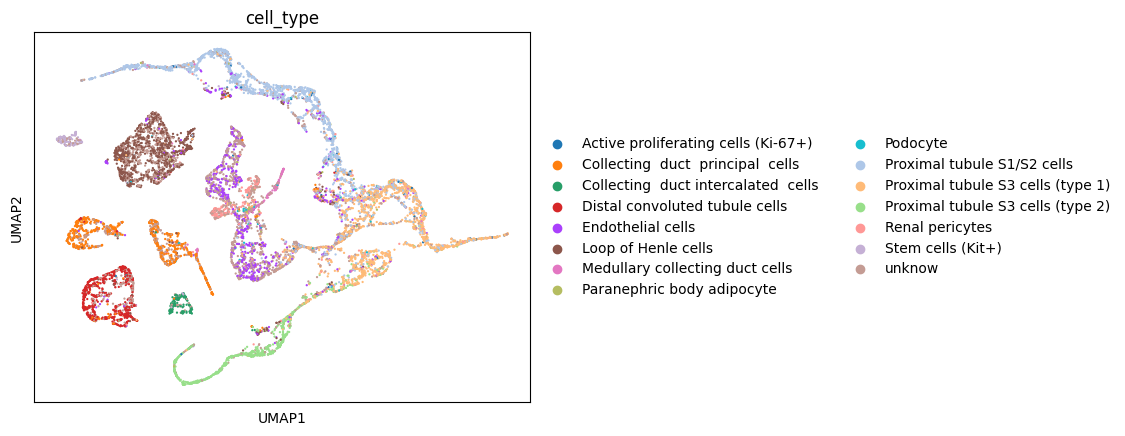

In [13]:
adata.obsm["MultiVI_latent"] = mvi.get_latent_representation()
sc.pp.neighbors(adata, use_rep="MultiVI_latent")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata, color='cell_type', title='cell_type')

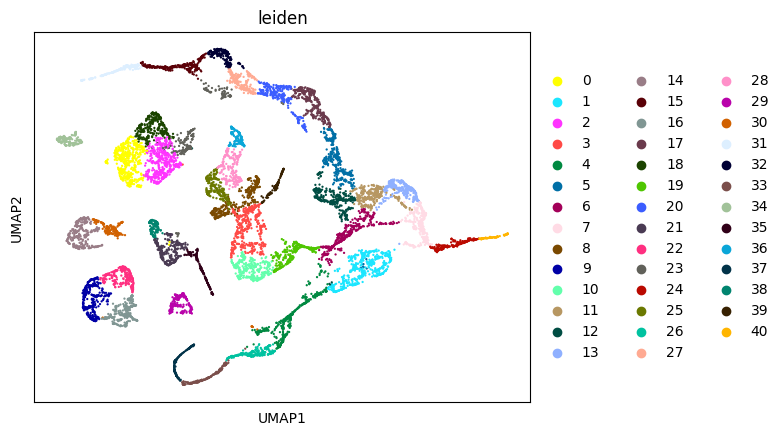

In [14]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden', title='leiden')

In [15]:
calculate_cluster_index(adata)

(0.13444028790023843,
 0.4253626768216722,
 0.43044645000458576,
 0.5643106773917966,
 0.34791500828845817,
 0.43044645000458576)